# Recap Previous Coding Project

We review the Previous Housing Project:

In [17]:
from pyspark.sql import SparkSession
# Build Sessnion
spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", 'Some-value') \
        .getOrCreate()

sc = spark.sparkContext
# https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html
# cal_housing.tgz
rdd = sc.textFile('../csv_data/cal_housing.data')
rdd = rdd.map(lambda line: line.split(','))
from pyspark.sql import Row
df = rdd.map(lambda line: Row(longitude=line[0], latitude=line[1], housingMedianAge=line[2], \
                              totalRoom=line[3], totalBedrooms =line[4], population = line[5], \
                              households = line[6], medianIncome=line[7], \
                              medianHouseValue=line[8])).toDF()

#df = spark.read.option("inferSchema","true").csv("../data/cal_housing.data").toDF( \
#        "longitude",  "latitude", "housingMedianAge", "totalRoom", "totalBedrooms", \
#        "population", "households", "medianIncome", "medianHouseValue")
#print('df.show():')
#print(df.show()) 
#print()

# Select the household and population
#df.select('households', 'population').show()

from pyspark.sql.functions import *
housePop = df.select(col('households')/col('population'))
#print('housePop:')
#print(housePop)
df = df.withColumn('housePop', col('households')/col('population'))

print('df.columns:')
print(df.columns)
print()

print('df.count():')
print(df.count())
print()
print("df.select('households', 'population').show():")
print(df.select('households', 'population').show())
print()
print("df[9]:")
print(df[9])
sc.stop()

df.columns:
['longitude', 'latitude', 'housingMedianAge', 'totalRoom', 'totalBedrooms', 'population', 'households', 'medianIncome', 'medianHouseValue', 'housePop']

df.count():
20640

df.select('households', 'population').show():
+-----------+-----------+
| households| population|
+-----------+-----------+
| 126.000000| 322.000000|
|1138.000000|2401.000000|
| 177.000000| 496.000000|
| 219.000000| 558.000000|
| 259.000000| 565.000000|
| 193.000000| 413.000000|
| 514.000000|1094.000000|
| 647.000000|1157.000000|
| 595.000000|1206.000000|
| 714.000000|1551.000000|
| 402.000000| 910.000000|
| 734.000000|1504.000000|
| 468.000000|1098.000000|
| 174.000000| 345.000000|
| 620.000000|1212.000000|
| 264.000000| 697.000000|
| 331.000000| 793.000000|
| 303.000000| 648.000000|
| 419.000000| 990.000000|
| 275.000000| 690.000000|
+-----------+-----------+
only showing top 20 rows

None

df[9]:
Column<b'housePop'>


# Collaborative Filtering

http://spark.apache.org/docs/latest/ml-collaborative-filtering.html
    
We discuss the Collaborative Filtering.

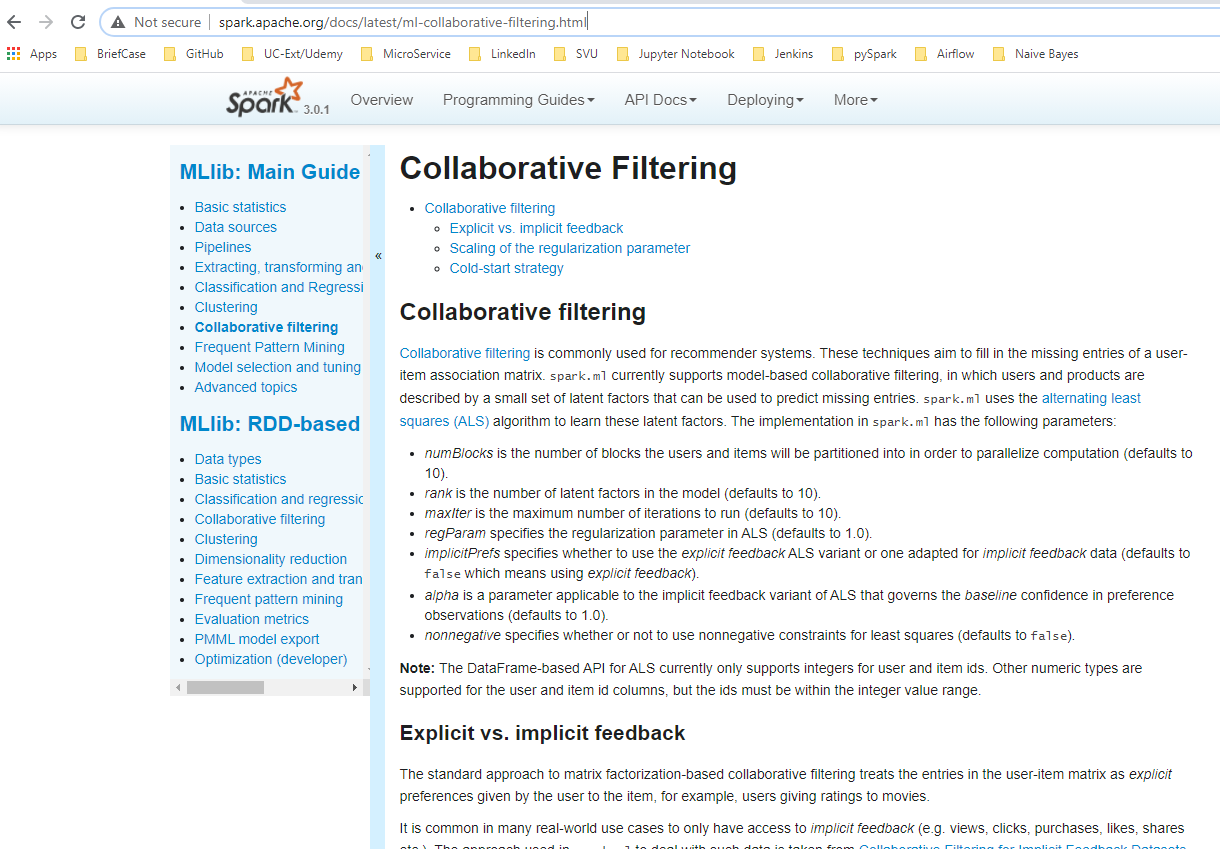

# Collaborative Filter

The Collaborative Filter is commonly used for recommender systems.

This technique aim to fill a missed entries of a user item association matrix. 

Spark MLlib supports model-based collaborative filtering in which the users and products are described by a small set of latent factors that can be used to protect missing entries.

The collaborative filtering are used every day in recommender systems.

Now, the Netflix is a typical recommender systems. 

If you watch a specific video on Netflix for a specific movie, you can see other recommended videos, movies, and shows based on specific features and data points within. 

- The Netflix takes an extensive amounts of data points to recommend users.
- If you apply for a job on dice.com, you can see other recommended jobs pop up that are similar.
- If you go to Amazon.com, you purchase something and you see other recommended or similar items.

These are recommender systems.

We may see some other techniques or multiple techniques combined.

Right now, we just look at collaborative filtering.


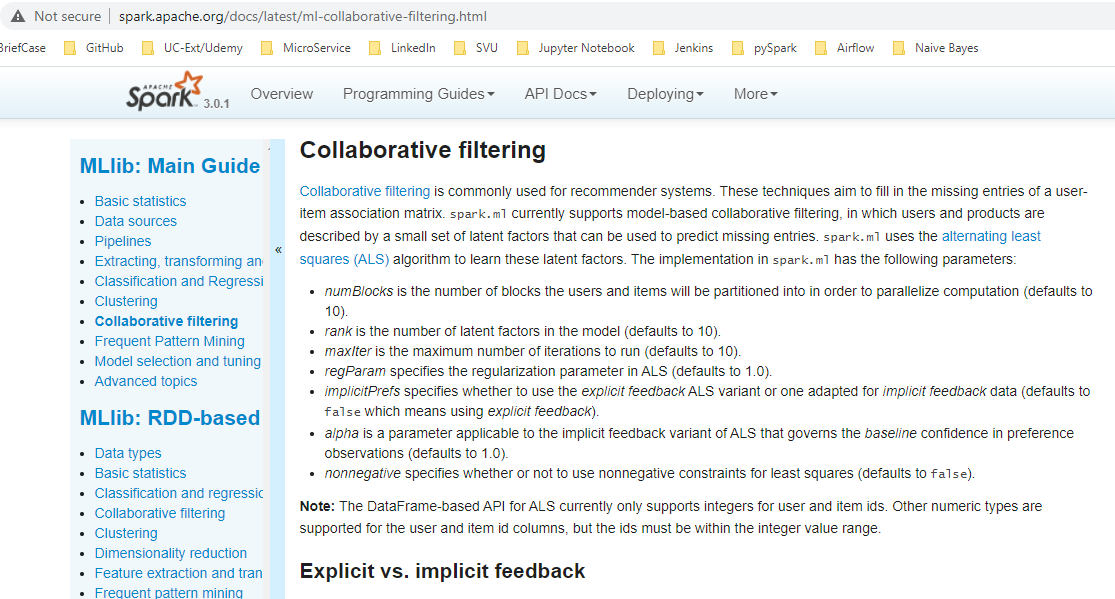

# Explicit vs. Implicit Feedback

We will discuss the Explicit and Implicit Feedback example that is provided by Apache Spark.

For explicit Feedback:

- The Matrix Factorization Collaborative Filtering is the standard approach.
- This Collaborative Filtering based on user feedback and rating for the movie.
- This Collaborative Filtering uses explicit preference from the user-item matrix for each items.

For implicit Feedback, we can see the views, click, purchase amounts, like, shares, and etc.

The MLlib collaborative filtering will use either explicit or implicit feedback datasets.

In the implicit feedback, in stead of model the matrix of ratings directly, this approach treat the data as number of representing the strengths and observations of users actions, such as number of clicks or cumulative duration someone spent viewing movie.

Those numbers are then related to the level of confidence and observed user preferences rather than explicit rating given to items. 

The model then tries t find latent factors that can be used to predict the expected preference.

The implicit feeback is sumamry as below:
    
- This approach treats the data as numbers representing the strength in observations of user actions (such as the number of clicks, or the cumulative duration someone spent viewing a movie). 
- Those numbers are then related to the level of confidence in observed user preferences, rather than explicit ratings given to items. The model then tries to find latent factors that can be used to predict the expected preference of a user for an item.

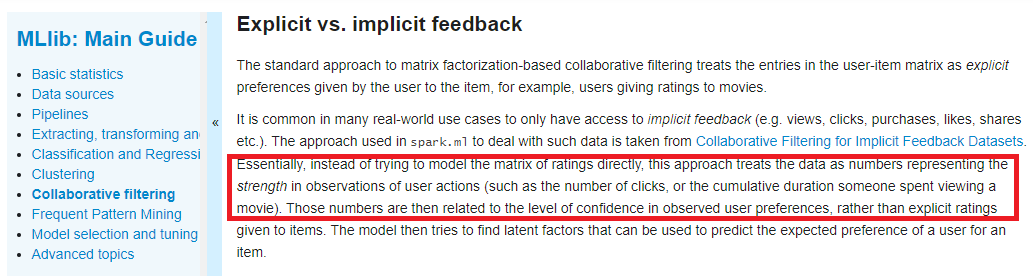

# Scale of the Regularization

We treat the data as numbers representing the strength in observations of users actions.

We represent the strength in observations, such as, click again, purchases, likes, shares.

We transform these strength into a data point that we can then use to scale and 
then to build our recommender systems.

For more information, we can read the information provided by MLlib.

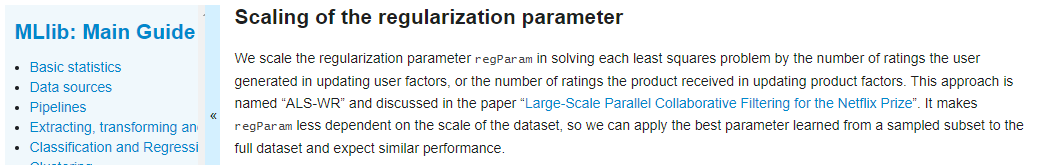

# Download Movie Dataset

https://github.com/apache/spark/blob/master/data/mllib/als/sample_movielens_ratings.txt

Copy to your local stroage.

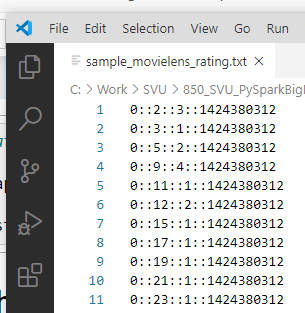

# PySark Machine Learning

http://spark.apache.org/docs/latest/ml-collaborative-filtering.html

In [1]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql import SparkSession
# Build Sessnion
spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", 'Some-value') \
        .getOrCreate()

sc = spark.sparkContext
lines = spark.read.text("./sample_movielens_ratings.txt").rdd
'''
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
lines = spark.read.text(".../csv_data/sample_movielens_ratings.txt").rdd
'''
parts = lines.map(lambda row: row.value.split("::"))
ratingsRDD = parts.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
                                     rating=float(p[2]), timestamp=int(p[3])))
ratings = spark.createDataFrame(ratingsRDD)
(training, test) = ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

# Generate top 10 movie recommendations for a specified set of users
users = ratings.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users, 10)
# Generate top 10 user recommendations for a specified set of movies
movies = ratings.select(als.getItemCol()).distinct().limit(3)
movieSubSetRecs = model.recommendForItemSubset(movies, 10)
sc.stop()

Root-mean-square error = 1.9714786844793784
